In [1]:
import numpy as np
import time
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
from torch.nn.parameter import Parameter

%matplotlib inline
import pylab as pl

from IPython import display
from copy import deepcopy
from skimage.transform import resize
from PIL import Image

In [6]:
# Set Important Values

data = '/data/dww78/mini_inat/'
gpu = 3
torch.cuda.set_device(gpu)
workers = 8
epoch = 20
start_epoch = 0
vbity = 20
esize = 4

way = 20
evalway = 5
trainshot = 5
testshot = 15

In [3]:
# Load Training/Testing Data

d_train = torch.load(data+'train_boxes.pth')
d_test = torch.load(data+'val_boxes.pth')
d_boxes = torch.load(data+'box_coords.pth')

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4905, 0.4961, 0.4330],std=[0.1737, 0.1713, 0.1779])
    ])

def load_transform(path, pathdict, boxdict, transform, size, flipping, masking):
    flip = np.random.choice([True, False])
    with open(path, 'rb') as f:
        p = Image.open(f)
        p = p.convert('RGB')
    w,h = p.size
    p = p.resize((size, size), Image.BILINEAR)
    if flip and flipping:
        p = p.transpose(Image.FLIP_LEFT_RIGHT)
    t = transform(p)
    if masking:
        mask = np.zeros((h,w))
        boxes = pathdict[path]
        for b in boxes:
            box = boxdict[b]
            xmin = box[0]
            xmax = box[2]+xmin
            ymin = box[1]
            ymax = box[3]+ymin
            if not flip or not flipping:
                mask[ymin:ymax, xmin:xmax] = 1
            else:
                mask[ymin:ymax, w-xmax:w-xmin] = 1
        mask = resize(mask, (size,size), mode='constant', cval=0)
        t = torch.cat([t, torch.FloatTensor(mask).unsqueeze(0)], dim=0)
    return t

class ProtoSampler(torch.utils.data.sampler.Sampler):
    def __init__(self, data_source, way):
        iddict = dict()
        for i,(_,cat) in enumerate(data_source.imgs):
            if cat in iddict:
                iddict[cat].append(i)
            else:
                iddict[cat] = [i]
        self.iddict = iddict
        self.way = way
        
    def __iter__(self):
        # Build new dictionary, shuffle entries
        trackdict = deepcopy(self.iddict)
        for key in trackdict:
            np.random.shuffle(trackdict[key])
        # Choose categories, sample, eliminate small categories
        idlist = []
        while len(trackdict.keys()) >= self.way:
            cats = np.random.choice(list(trackdict.keys()), size=self.way, replace=False)
            for cat in cats:
                for _ in range(trainshot):
                    idlist.append(trackdict[cat].pop())
            for cat in cats:
                for _ in range(testshot):
                    idlist.append(trackdict[cat].pop())
                if len(trackdict[cat]) < trainshot+testshot:
                    trackdict.pop(cat)
            # TODO: shuffle idlist batches
            yield idlist
            idlist = []

train_dataset = datasets.ImageFolder(
    data+'train', 
    loader = lambda x: load_transform(x, d_train, d_boxes, transform, 84, True, False))
test_dataset = datasets.ImageFolder(
    data+'val',
    loader = lambda x: load_transform(x, d_test, d_boxes, transform, 84, False, False))
train_loader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_sampler = ProtoSampler(train_dataset, way),
    num_workers = workers,
    pin_memory = True)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_sampler = ProtoSampler(test_dataset, evalway),
    num_workers = workers,
    pin_memory = True)
print('Data loaded!')
print(len(train_dataset.classes), len(test_dataset.classes))

Data loaded!
908 227


In [4]:
# Define the Procedures

def train(train_loader, epoch, gpu, vbity):
    for model in smodel:
        model.train()
    targ = Variable(torch.LongTensor([i//testshot for i in range(testshot*way)])).cuda(
        device = gpu, async=True)
    allloss = [0]*esize
    for i, (inp, _) in enumerate(train_loader):
        inp = Variable(inp).cuda(device = gpu, async=True)
        
        for j in range(esize):
            smodel[j].zero_grad()
            out = predictor(smodel[j](inp), way, trainshot)
            loss = criterion(out, targ)
            loss.backward()
            soptimizer[j].step()
        
            allloss[j] += loss.item()
            
        if i%vbity == 0:
            print('%d of approx. 192270'%(i*way*(trainshot+testshot)))
    return [L/i for L in allloss]

def validate(val_loader, gpu, vbity, reps, verbose):
    for model in smodel:
        model.eval()
    targ = Variable(torch.LongTensor([i//testshot for i in range(testshot*evalway)])).cuda(
        device = gpu, async=True)
    allloss = [0]*esize
    acctracker = [[] for _ in range(esize)]
    for r in range(reps):
        for i, (inp, _) in enumerate(val_loader):
            inp = Variable(inp).cuda(device = gpu, async=True)

            with torch.no_grad():
                for j in range(esize):
                    out = predictor(smodel[j](inp), evalway, trainshot)
                    loss = criterion(out, targ)
                    allloss[j] += loss.item()
                    _,bins = torch.max(out,1)
                    acc = torch.sum(torch.eq(bins,targ)).item()/testshot/evalway
                    acctracker[j].append(acc)
            if i%vbity == 0 and verbose:
                print('Round %d of %d, %d of approx. 51716'%(r+1, reps, i*evalway*(trainshot+testshot)))
    return [L/i for L in allloss], [np.mean(a) for a in acctracker], [1.96*np.sqrt(np.var(a)/len(a)) for a in acctracker]

print('Ready to go!')

Ready to go!


In [7]:
# Make Models

class Block(nn.Module):
    def __init__(self, insize, outsize):
        super(Block, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(insize, outsize, kernel_size=3, padding=1),
            nn.BatchNorm2d(outsize)
        )
        
    def forward(self, inp):
        return self.layers(inp)

class PROTO(nn.Module):
    def __init__(self):
        super(PROTO, self).__init__()
        self.process = nn.Sequential(
            Block(3,64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            Block(64,64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            Block(64,64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            Block(64,64),
            nn.AvgPool2d(10)
        )
        
    def forward(self, inp):
        return self.process(inp).view(inp.size(0),-1)
        
class Predictor(nn.Module):
    def __init__(self):
        super(Predictor, self).__init__()
        self.sm = nn.LogSoftmax(dim=-1)
        
    def forward(self, inp, way, trainshot):
        support = inp[:way*trainshot].view(way,-1,inp.size(-1)).mean(1).squeeze()
        distmat = torch.sum((support.unsqueeze(0)-inp[way*trainshot:].unsqueeze(1))**2,2).squeeze().neg()
        probs = self.sm(distmat)
        return probs
    
smodel = [PROTO().cuda() for i in range(esize)]
qmodel = [PROTO().cuda() for i in range(esize)]
predictor = Predictor().cuda()
soptimizer = [optim.Adam(m.parameters(), lr=.001) for m in smodel]
qoptimizer = [optim.Adam(m.parameters(), lr=.001) for m in qmodel]
sscheduler = [optim.lr_scheduler.LambdaLR(o, lambda x: 1/(2**x)) for o in soptimizer]
qscheduler = [optim.lr_scheduler.LambdaLR(o, lambda x: 1/(2**x)) for o in qoptimizer]
criterion = nn.NLLLoss().cuda()
cudnn.benchmark = True

nweights = sum([i.numel() for i in list(smodel[0].parameters())])
print(nweights," parameters in each neural net.")

113088  parameters in each neural net.


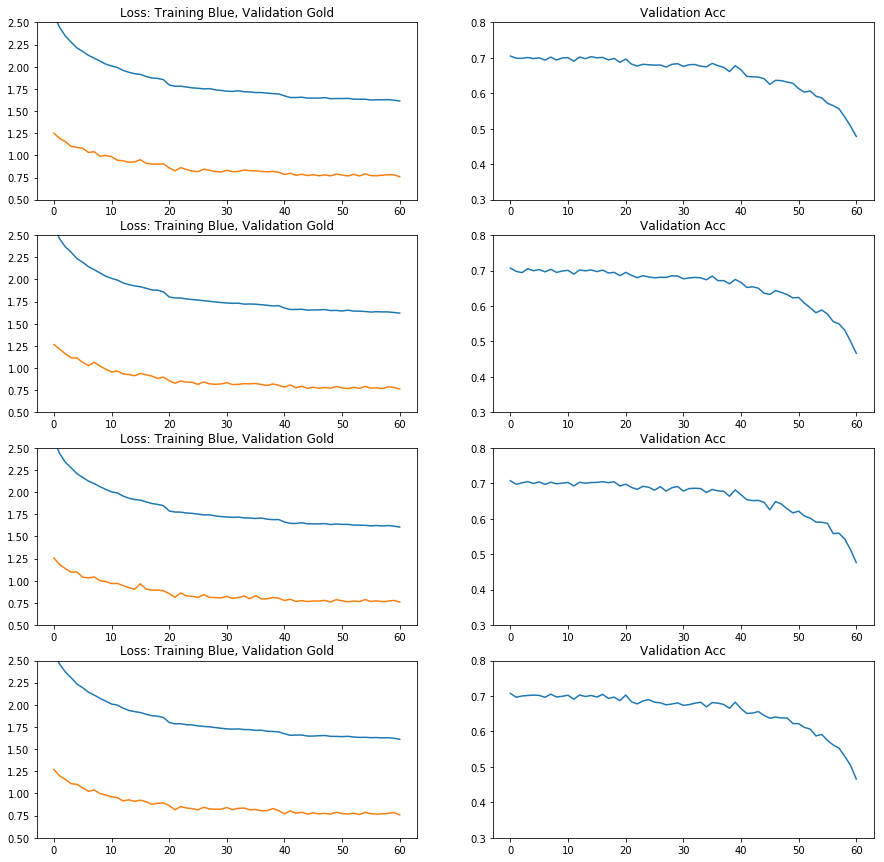

Train loss is: [1.6123337607822785, 1.6198781195238265, 1.6063075622092988, 1.6111674318987501]
Validation accuracy is: [0.7050909090909091, 0.7068181818181818, 0.7072121212121213, 0.7072121212121213]
Validation loss is: [0.7587205039884615, 0.764318379834464, 0.7590505032713158, 0.758963669486904]

11.90 hours to completion

0 of approx. 192270
8000 of approx. 192270
16000 of approx. 192270
24000 of approx. 192270
32000 of approx. 192270
40000 of approx. 192270
48000 of approx. 192270
56000 of approx. 192270
64000 of approx. 192270


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [8]:
# Do the Thing!

start = time.time()
trainlosses, testlosses, acctracker = [[] for _ in range(esize)],[[] for _ in range(esize)],[[] for _ in range(esize)]
epochs = 5*epoch
for e in range(epochs):
    # Adjust learnrate
    if e%epoch == 0:
        [s.step() for s in sscheduler]
        [q.step() for q in qscheduler]
    
    # Train for one epoch
    trainloss = train(train_loader, e, gpu, vbity)
    
    # Evaluate, single pass
    testloss, acc, _ = validate(test_loader, gpu, vbity, 1, True)
    
    # update the precision graph, report
    display.clear_output(wait=True)
    for j in range(esize):
        trainlosses[j].append(trainloss[j])
        testlosses[j].append(testloss[j])
        acctracker[j].append(acc[j])
    pl.figure(1, figsize=(15,15))
    for i in range(esize):
        pl.subplot(esize,2,2*i+1)
        pl.plot(trainlosses[i])
        pl.plot(testlosses[i])
        pl.ylim((.5,2.5))
        pl.title("Loss: Training Blue, Validation Gold")
        pl.subplot(esize,2,2*i+2)
        pl.plot(acctracker[i][::-1])
        pl.ylim((0.3,.8))
        pl.title("Validation Acc")
    pl.show()
    print("Train loss is: "+str(trainloss)+
            "\nValidation accuracy is: "+str(acc)+
            "\nValidation loss is: "+str(testloss)+"\n")
    
    print("%.2f hours to completion"%(  (time.time()-start)/(e+1)*(epochs-e)/3600  ))
    print()
print((time.time()-start)/3600, "hours total") 
_, score, conf = validate(test_loader, gpu, vbity, 10, False)
for i in range(esize):
    print('Model %d final score: %.2f +- %.2f'%(i, score[i]*100, conf[i]*100))

In [9]:
torch.save(((trainlosses, testlosses, acctracker), 
            tuple([m.state_dict() for m in smodel]),  
            tuple([o.state_dict() for o in soptimizer]),
           ), 'saved_models/retraining_nomask_baseline_doubled.torch')

In [11]:
_, score, conf = validate(test_loader, gpu, vbity, 10, True)
for i in range(esize):
    print('Model %d final score: %.2f +- %.2f'%(i, score[i]*100, conf[i]*100))

Round 1 of 10, 0 of approx. 51716
Round 1 of 10, 2000 of approx. 51716
Round 1 of 10, 4000 of approx. 51716
Round 1 of 10, 6000 of approx. 51716
Round 1 of 10, 8000 of approx. 51716
Round 1 of 10, 10000 of approx. 51716
Round 1 of 10, 12000 of approx. 51716
Round 1 of 10, 14000 of approx. 51716
Round 1 of 10, 16000 of approx. 51716
Round 1 of 10, 18000 of approx. 51716
Round 1 of 10, 20000 of approx. 51716
Round 1 of 10, 22000 of approx. 51716
Round 1 of 10, 24000 of approx. 51716
Round 1 of 10, 26000 of approx. 51716
Round 1 of 10, 28000 of approx. 51716
Round 1 of 10, 30000 of approx. 51716
Round 1 of 10, 32000 of approx. 51716
Round 1 of 10, 34000 of approx. 51716
Round 1 of 10, 36000 of approx. 51716
Round 1 of 10, 38000 of approx. 51716
Round 1 of 10, 40000 of approx. 51716
Round 1 of 10, 42000 of approx. 51716
Round 2 of 10, 0 of approx. 51716
Round 2 of 10, 2000 of approx. 51716
Round 2 of 10, 4000 of approx. 51716
Round 2 of 10, 6000 of approx. 51716
Round 2 of 10, 8000 of appr

Round 10 of 10, 40000 of approx. 51716
Round 10 of 10, 42000 of approx. 51716
Model 0 final score: 70.85 +- 0.29
Model 1 final score: 70.90 +- 0.29
Model 2 final score: 71.17 +- 0.29
Model 3 final score: 70.89 +- 0.29


In [ ]:
#                                             RETRAINING

In [6]:
ts,m,o = torch.load('saved_models/retraining_nomask_baseline.torch')
for i in range(esize):
    smodel[i].load_state_dict(m[i])
    soptimizer[i].load_state_dict(o[i])
    qmodel[i].load_state_dict(m[i])
    qoptimizer[i].load_state_dict(o[i])
trainlosses, testlosses, acctracker = ts

In [7]:
# New predictor

class Predictor(nn.Module):
    def __init__(self):
        super(Predictor, self).__init__()
        self.sm = nn.LogSoftmax(dim=-1)
        
    def forward(self, inp, query, way):
        support = inp.view(way,-1,inp.size(-1)).mean(1).squeeze()
        distmat = torch.sum((support.unsqueeze(0)-query.unsqueeze(1))**2,2).squeeze().neg()
        probs = self.sm(distmat)
        return probs

predictor = Predictor().cuda()

In [8]:
# Define the Procedures

def train(train_loader, epoch, gpu, vbity):
    for model in smodel:
        model.train()
    for model in qmodel:
        model.train()
    targ = Variable(torch.LongTensor([i//testshot for i in range(testshot*way)])).cuda(
        device = gpu, async=True)
    allloss = [0]*esize
    for i, (inp, _) in enumerate(train_loader):
        inp = Variable(inp).cuda(device = gpu, async=True)
        
#         # Zero out the masks
#         inp[way*trainshot:,-1,:,:] = 0
        
        for j in range(esize):
            smodel[j].zero_grad()
            qmodel[j].zero_grad()
            out = predictor(smodel[j](inp[:way*trainshot]), qmodel[j](inp[way*trainshot:]), way)
            loss = criterion(out, targ)
            loss.backward()
            soptimizer[j].step()
            qoptimizer[j].step()
        
            allloss[j] += loss.item()
            
        if i%vbity == 0:
            print('%d of approx. 192270'%(i*way*(trainshot+testshot)))
    return [L/i for L in allloss]

def validate(val_loader, gpu, vbity, reps, verbose):
    for model in smodel:
        model.eval()
    for model in qmodel:
        model.eval()
    targ = Variable(torch.LongTensor([i//testshot for i in range(testshot*evalway)])).cuda(
        device = gpu, async=True)
    allloss = [0]*esize
    acctracker = [[] for _ in range(esize)]
    for r in range(reps):
        for i, (inp, _) in enumerate(val_loader):
            inp = Variable(inp).cuda(device = gpu, async=True)
            
#             # Zero out the masks
#             inp[evalway*trainshot:,-1,:,:] = 0

            with torch.no_grad():
                for j in range(esize):
                    out = predictor(smodel[j](inp[:evalway*trainshot]), qmodel[j](inp[evalway*trainshot:]), evalway)
                    loss = criterion(out, targ)
                    allloss[j] += loss.item()
                    _,bins = torch.max(out,1)
                    acc = torch.sum(torch.eq(bins,targ)).item()/testshot/evalway
                    acctracker[j].append(acc)
            if i%vbity == 0 and verbose:
                print('Round %d of %d, %d of approx. 51716'%(r+1, reps, i*evalway*(trainshot+testshot)))
    return [L/i for L in allloss], [np.mean(a) for a in acctracker], [1.96*np.sqrt(np.var(a)/len(a)) for a in acctracker]

print('Ready to go!')

Ready to go!


In [ ]:
# Do the Thing!

start = time.time()
# trainlosses, testlosses, acctracker = [[] for _ in range(esize)],[[] for _ in range(esize)],[[] for _ in range(esize)]
epochs = 5*epoch
for e in range(epochs):
    # Adjust learnrate
    if e%epoch == 0:
        [s.step() for s in sscheduler]
        [q.step() for q in qscheduler]
    
    # Train for one epoch
    trainloss = train(train_loader, e, gpu, vbity)
    
    # Evaluate, single pass
    testloss, acc, _ = validate(test_loader, gpu, vbity, 1, True)
    
    # update the precision graph, report
    display.clear_output(wait=True)
    for j in range(esize):
        trainlosses[j].append(trainloss[j])
        testlosses[j].append(testloss[j])
        acctracker[j].append(acc[j])
    pl.figure(1, figsize=(15,15))
    for i in range(esize):
        pl.subplot(esize,2,2*i+1)
        pl.plot(trainlosses[i])
        pl.plot(testlosses[i])
        pl.axvline(x=49)
        pl.ylim((.5,2.5))
        pl.title("Loss: Training Blue, Validation Gold")
        pl.subplot(esize,2,2*i+2)
        pl.plot(acctracker[i][::-1])
        pl.axvline(x=len(trainlosses[i])-50)
        pl.ylim((0.3,.8))
        pl.title("Validation Acc")
    pl.show()
    print("Train loss is: "+str(trainloss)+
            "\nValidation accuracy is: "+str(acc)+
            "\nValidation loss is: "+str(testloss)+"\n")
    
    print("%.2f hours to completion"%(  (time.time()-start)/(e+1)*(epochs-e)/3600  ))
    print()
print((time.time()-start)/3600, "hours total") 
_, score, conf = validate(test_loader, gpu, vbity, 10, False)
for i in range(esize):
    print('Model %d final score: %.2f +- %.2f'%(i, score[i]*100, conf[i]*100))

In [ ]:
torch.save(((trainlosses, testlosses, acctracker), 
            [m.state_dict() for m in smodel], 
            [m.state_dict() for m in qmodel]
           ), 'saved_models/retrained_nomask_baseline.torch')

In [ ]:
%%javascript
Jupyter.notebook.session.delete();

In [ ]:
# First run: 73.26 +- .25

In [ ]:
#                                            MAX WAY EVALUATION

In [6]:
_,m,_ = torch.load('saved_models/retraining_final.torch')
for i in range(esize):
    smodel[i].load_state_dict(m[i])
    qmodel[i].load_state_dict(m[i])
gpus = [2,3]
smodel = [nn.parallel.DataParallel(model, device_ids = gpus).cuda(device = gpus[0]) for model in smodel]
qmodel = [nn.parallel.DataParallel(model, device_ids = gpus).cuda(device = gpus[0]) for model in qmodel]

evalway = 227

In [7]:
def validate(val_loader, gpu, vbity, reps, verbose):
    for model in smodel:
        model.eval()
    for model in qmodel:
        model.eval()
    targ = Variable(torch.LongTensor([i//testshot for i in range(testshot*evalway)])).cuda(
        device = gpus[0], async=True)
    allloss = [0]*esize
    acctracker = [[] for _ in range(esize)]
    for r in range(reps):
        for i, (inp, _) in enumerate(val_loader):
            inp = Variable(inp).cuda(device = gpus[0], async=True)
            
            # Zero out the masks
            inp[evalway*trainshot:,-1,:,:] = 0

            with torch.no_grad():
                for j in range(esize):
                    out = predictor(smodel[j](inp[:evalway*trainshot]), qmodel[j](inp[evalway*trainshot:]), evalway)
                    loss = criterion(out, targ)
                    allloss[j] += loss.item()
                    _,bins = torch.max(out,1)
                    acc = torch.sum(torch.eq(bins,targ)).item()/testshot/evalway
                    acctracker[j].append(acc)
        if verbose:
            print('Round %d of %d'%(r+1, reps))
    return [L/i for L in allloss], [np.mean(a) for a in acctracker], [1.96*np.sqrt(np.var(a)/len(a)) for a in acctracker]

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_sampler = ProtoSampler(test_dataset, evalway),
    num_workers = workers,
    pin_memory = True)

_, score, conf = validate(test_loader, gpu, vbity, 100, True)
for i in range(esize):
    print('Model %d final score: %.2f +- %.2f'%(i, score[i]*100, conf[i]*100))

Round 1 of 100
Round 2 of 100
Round 3 of 100
Round 4 of 100
Round 5 of 100
Round 6 of 100
Round 7 of 100
Round 8 of 100
Round 9 of 100
Round 10 of 100
Round 11 of 100
Round 12 of 100
Round 13 of 100
Round 14 of 100
Round 15 of 100
Round 16 of 100
Round 17 of 100
Round 18 of 100
Round 19 of 100
Round 20 of 100
Round 21 of 100
Round 22 of 100
Round 23 of 100
Round 24 of 100
Round 25 of 100
Round 26 of 100
Round 27 of 100
Round 28 of 100
Round 29 of 100
Round 30 of 100
Round 31 of 100
Round 32 of 100
Round 33 of 100
Round 34 of 100
Round 35 of 100
Round 36 of 100
Round 37 of 100
Round 38 of 100
Round 39 of 100
Round 40 of 100
Round 41 of 100
Round 42 of 100
Round 43 of 100
Round 44 of 100
Round 45 of 100
Round 46 of 100
Round 47 of 100
Round 48 of 100
Round 49 of 100
Round 50 of 100
Round 51 of 100
Round 52 of 100
Round 53 of 100
Round 54 of 100
Round 55 of 100
Round 56 of 100
Round 57 of 100
Round 58 of 100
Round 59 of 100
Round 60 of 100
Round 61 of 100
Round 62 of 100
Round 63 of 100
R

In [ ]:
%%javascript
Jupyter.notebook.session.delete();

<IPython.core.display.Javascript object>

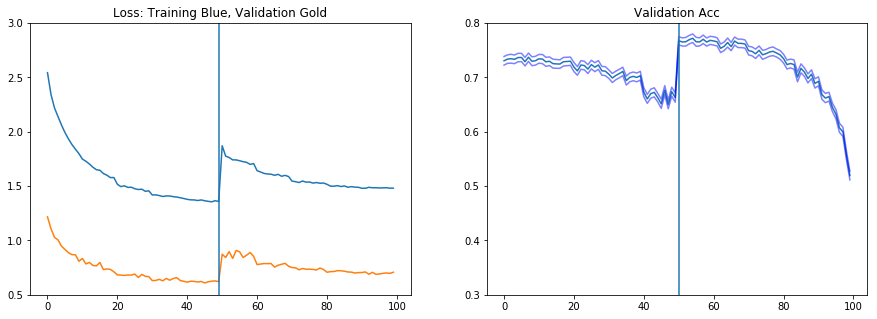

Train loss is: 1.4811082482337952
Validation accuracy is: 0.7304918032786886
Validation loss is: 0.707609014803624

0.26 hours to completion

12.953958654469915
Final score: 73.26 +- 0.25


In [7]:
# Do the Thing!

start = time.time()
epochs = 5*epoch
for e in range(epochs):
    # Adjust learnrate
    if e%epoch == 0:
        sscheduler.step()
        qscheduler.step()
    
    # Train for one epoch
    trainloss = train(train_loader, e, gpu, vbity)
    
    # Evaluate, single pass
    testloss, acc, spread = validate(test_loader, gpu, vbity, 1, True)
    
    # update the precision graph, report
    display.clear_output(wait=True)
    trainlosses.append(trainloss)
    testlosses.append(testloss)
    acctracker.append(acc)
    spreadtracker.append(spread)
    pl.figure(1, figsize=(15,5))
    pl.subplot(1,2,1)
    pl.plot(trainlosses)
    pl.plot(testlosses)
    pl.axvline(x=49)
    pl.ylim((.5,3))
    pl.title("Loss: Training Blue, Validation Gold")
    pl.subplot(1,2,2)
    pl.plot(acctracker[::-1])
    pl.plot(np.array(acctracker[::-1])-np.array(spreadtracker[::-1]), alpha=.5, c='blue')
    pl.plot(np.array(acctracker[::-1])+np.array(spreadtracker[::-1]), alpha=.5, c='blue')
    pl.axvline(x=len(trainlosses)-50)
    pl.ylim((0.3,.8))
    pl.title("Validation Acc")
    pl.show()
    print("Train loss is: "+str(trainloss)+
            "\nValidation accuracy is: "+str(acc)+
            "\nValidation loss is: "+str(testloss)+"\n")
    
    print("%.2f hours to completion"%(  (time.time()-start)/(e+1)*(epochs-e)/3600  ))
    print()
print((time.time()-start)/3600) 
_, score, conf = validate(test_loader, gpu, vbity, 10, False)
print('Final score: %.2f +- %.2f'%(score*100, conf*100))